#Graphs for CAD people to make decisions and maybe for documentation

These graphs demonstrate the functionality of the model and hopefully provide some insight into what the graphs represent. In general, I have tried to comment the code to make it readable, but ask if there's anything thats confusing.

To see the graphs at a higher resolution, to read them better or for screenshots for the development log, replace the ```%matplotlib inline``` with ```matplotlib qt```

This notebook has the launcher module included in it, a more condensed version is avaliable [here](https://github.com/mkf1g21/launcher/blob/main/CAD%20graphs.ipynb). If you are viewing this in github, its probably worth usign the other one, but if you are viewing it locally and you are having issues getting that to run, this one will work better.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Launcher:
    # constants
    g = -9.81
    m = 0.024  # https://www.dimensions.com/element/squash-ball
    d = 0.040

    # variables
    u_x = 0
    u_y = 0
    theta = 0  # in radians
    exit_velocity = 0
    c_d = 1
    times = []


    bungee_length = 0.5
    eta = 0.9

    # TODO: continuous angle with 2 power settings

    """------------------------------trajectory-----------------------------"""

    def get_CD(self, V_mag):
        rho = 1.204    # kg/m^3
        mu = 1.825e-5  # Pa s
        Re = rho * V_mag * self.d / mu
        return (24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38)))

    def set_components(self, x, y):
        """sets the components of velocity from the x and y components.
        automatically finds the launch angle and speed"""
        self.u_x = x
        self.u_y = y
        self.exit_velocity = (x ** 2 + y ** 2) ** 0.5
        self.theta = np.arctan(y / x)

    def set_angles(self, exit_velocity, theta):
        """sets launch angle and exit velocity. automatically sets the
        components of velocity in x and y"""
        self.exit_velocity = exit_velocity
        self.theta = theta
        self.u_x = exit_velocity * np.cos(theta)
        self.u_y = exit_velocity * np.sin(theta)

    def setExitVelocity(self, force, distance, angle, C_f=0, degrees=True):
        """sets the distance the ball will travel while under acceleration.
        Needs the angle to still work with the rest of
        the code"""
        #TODO change to use coefficient of friction, needs a more complex suvat because of changing a
        v = (2 * (force / self.m) * distance) ** 0.5
        self.exit_velocity = v
        if degrees:
            self.theta = np.radians(angle)
        else:
            self.theta = angle

    def get_time_of_flight(self, u=0):
        """returns the time the ball is in the air, assumes start and final
        height are the same"""
        if u:
            return (2 * u) / abs(self.g)
        else:
            return (2 * self.u_y) / abs(self.g)

    def feeg1002_Range(self, mag, theta):
        """one of the equations from dynamics to find range, ignores drag"""
        return -np.sin(2 * theta) * mag ** 2 / self.g 

    def get_range_drag(self, dt=0, mag=0, theta=0):
        """numerically finds the distance the ball should travel including drag"""
        height = 0
        distance = 0
        if mag and theta:
            v_x = mag * np.cos(theta)
            v_y = mag * np.sin(theta)
        else:
            v_x = self.u_x
            v_y = self.u_y
        a_x = 0
        a_y = 0

        rho = 1.225

        area = np.pi * (0.5 * self.d) ** 2
        if dt:
            dt = dt
        else:
            dt = self.get_time_of_flight(v_y) / 1000
        
        while True:
            height = height + v_y * dt
            distance = distance + v_x * dt

            a_x = rho * 0.5 * self.get_CD((v_x** 2 + v_y ** 2) ** 0.5) * v_x ** 2 * area * -1
            a_y = (rho * 0.5 * self.get_CD((v_x** 2 + v_y ** 2)** 0.5) * v_y ** 2 * area * -1) + self.g

            v_y = v_y + a_y * dt
            v_x = v_x + a_x * dt
            # print(v_x, v_y, a_x, a_y, height)

            if height <= 0:
                break
        return(distance)
        # plt.plot(vs)

    def plot_angle_v_range(self, dt=0, angle = np.NaN):# ADD COMMMENTS TO MAKE IT UUNDERSTANDABLE
        """plots the distance the projectile gets to across angles, one with
        and one without drag"""
        angles = np.linspace(0, (np.pi) / 2, num=180)
        
        #some if statements to deal with if we want to specify a timestep or let the computer decide
        if dt:
            dRanges = [self.get_range_drag(dt, self.exit_velocity, theta) for theta in angles]
        else:
            dRanges = [self.get_range_drag(mag=self.exit_velocity, theta=theta) for theta in angles]
        
        #theoretical ranges
        feeg1002ranges = [self.feeg1002_Range(self.exit_velocity, theta) for theta in angles]
        
        plt.plot(np.degrees(angles), dRanges, label="including drag")
        plt.plot(np.degrees(angles), feeg1002ranges, label="ranges from dynamics")
        plt.xlabel("tube angle (°)")
        plt.ylabel("distance (m)")
        plt.title
        plt.legend()
        plt.yticks([1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5])#shows the different ranges
        plt.grid()
        plt.show()

    """------------------------launch mechanism----------------------------"""
    


    def bow_exit_velocity(self, cart_disp, arm_length, relaxed_elastic, bungee_const, mtot, eta):
        """
        Compute launch velocity from launcher settings.
        """
    # length of bungee before firing
        stretched_bungee = np.sqrt(arm_length ** 2 + cart_disp ** 2)

        return np.sqrt( (eta * bungee_const * (stretched_bungee-relaxed_elastic)**2 - bungee_const * (arm_length-relaxed_elastic)**2) / mtot )




l=Launcher()


## Exit velocity against relaxed length of cord

This graph shows that even with pessimistic assumptions (300g cart, 50% efficiency), 8.5 m/s is achievable. This graph **assumes the arms on the launcher are 1.1x the length of the elastic at rest**. by varying the values in the for loop, other cart displacements/power settings can be tried.

A lower length ratio corresponds to shorter arms, and has the effect of making the gradient more negative throughout the length of the graph

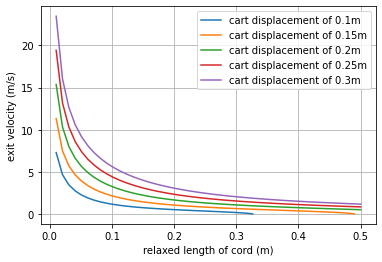

In [2]:
%%capture --no-display
%matplotlib inline
plt.figure(1)
plt.clf()

length_ratio = 1.1

relaxeds = np.linspace(0,0.5)

for displacement in [0.1,0.15,0.2,0.25,0.3]: #power settings
    velocities = [l.bow_exit_velocity(displacement, length_ratio * relaxed, relaxed, 2 * 20/relaxed, 0.3,0.5) for relaxed in relaxeds]
    plt.plot(relaxeds, velocities, label="cart displacement of " + str(displacement) + "m")
plt.xlabel("relaxed length of cord (m)")
plt.ylabel("exit velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

With a more realistic set of values, 100g cart and 80% efficiency, we can use less displacement to get the same range, staying better within the elastic range of the cord and increasing precision, because of the lower gradient of the line

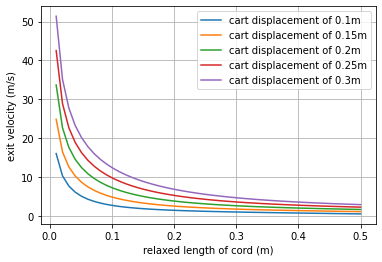

In [3]:
%%capture --no-display
%matplotlib inline
plt.figure(1)
plt.clf()

length_ratio = 1.1

relaxeds = np.linspace(0,0.5)

for displacement in [0.1,0.15,0.2,0.25,0.3]: #power settings
    velocities = [l.bow_exit_velocity(displacement, length_ratio * relaxed, relaxed, 2 * 20/relaxed, 0.1,0.8) for relaxed in relaxeds]
    plt.plot(relaxeds, velocities, label="cart displacement of " + str(displacement) + "m")
plt.xlabel("relaxed length of cord (m)")
plt.ylabel("exit velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

At an exit velocity of 8.5, every distance is well within reach, but precision will be low

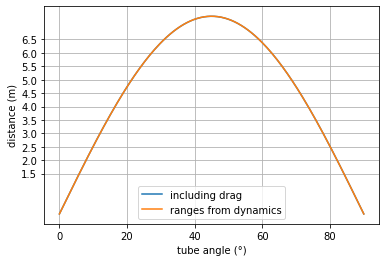

In [4]:
%matplotlib inline
l.set_angles(8.5,0)
l.plot_angle_v_range()

Graph demonstrating the different launch velocities and their maximum range. For the region we are interested in (2 - 6 meters) the line can probably be approximated to be linear. The 40° line isn't visible because the 50° line covers it.

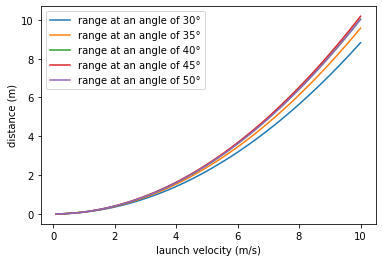

In [5]:
%matplotlib inline
plt.figure(2)
plt.clf()
l.set_angles(0,45)

velocities = np.linspace(0.1,10)

for angle in [30,35,40,45,50]:
    ranges = [l.get_range_drag(mag=velocity, theta = np.radians(angle)) for velocity in velocities]
    plt.plot(velocities, ranges, label="range at an angle of " + str(angle)+ "°")

plt.xlabel("launch velocity (m/s)")
plt.ylabel("distance (m)")
plt.legend()
plt.show()

